In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from utility.get_twitter import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import sys

# Load data

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
data = pd.read_csv('../data/tagged_tweets.csv')
data.head()

,tweet_id,tweet,revelant,sighting,lost_pet,coyote_death,eating,pet_coyote_interaction,traffic,howling
0,1.455952e+14,@OnlineAlison Several comments later… “I feed the coyotes!”,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.455952e+14,@johnlevenstein If we hadn’t defunded police there wouldn’t be so many coyotes!!!!!!!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.455933e+14,@TheOGpianoGeek That her COYOTE dues are late...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.455932e+14,"Hey Coyotes! There is a virtual PFC meeting next Wednesday, November 10th at 9:00 am. You don't wanna miss it. Click here for the Zoom link: https://t.co/2t8f4T7c9W or go to our website. #coyotepride #CHSPFC https://t.co/HDtuuiKqou",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.455930e+14,"@DunkaPeacecraft The Dems have been in power for a year, they've done nothing with it and thus have nothing to campaign on so they're forced to pull stunts like this that are sure to blow up in their face Wile E Coyote style.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`tweet` is `X` `revelant` is `y`

In [4]:
X = data['tweet']
y = data['revelant']
X.shape, y.shape

((422,), (422,))

In [5]:
y[y == 1].shape, y[y == 0].shape

((105,), (317,))

# Split data into train, validation, test

In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.4, stratify=None)
X_train.shape, X_val_test.shape, y_train.shape, y_val_test.shape

((253,), (169,), (253,), (169,))

# Split val_test into validation and test

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, stratify=None)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((84,), (84,), (85,), (85,))

In [8]:
# Check dim of training, validation, and test sets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((253,), (253,), (84,), (84,), (85,), (85,))

In [9]:
y_train[y_train==1].sum(), y_val[y_val==1].sum(), y_test[y_test==1].sum()

(63.0, 25.0, 17.0)

Training will be used to train all the models, validation will be used to select best model, and test will be used to test the final model

# Make Scorer for Cross Validation

The scorer or metric im going to use to gauge how good a model is logloss

In [10]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create function to measure metrics

The loss we will be optimizing for is logloss

In [11]:
def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.5f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Candidate models

The following are the models I will be selecting from:
- CountVector -> NB
- TFIDF -> NB
- CountVector -> SVG
- TFIDF -> SVG

# Model 1: Count -> NB

In [12]:
count_vec = CountVectorizer(strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', nb)])
params = {
    'wordcount__preprocessor': [tweet_preprocessor],
    'wordcount__ngram_range': [(1,2), (1,1)],
    'wordcount__stop_words': ['english'],
    'wordcount__min_df': [0, 1, 2],
    'wordcount__lowercase': [True, False],
    'bayes__alpha': [1, 2],
}

In [13]:
%%time
wcnb = GridSearchCV(pipeline, param_grid=params, verbose=50, n_jobs=-1, cv=3, scoring=LogLoss)
wcnb.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 2.72 s, sys: 195 ms, total: 2.91 s
Wall time: 48.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('wordcount',
                                        CountVectorizer(strip_accents='ascii')),
                                       ('bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [1, 2],
                         'wordcount__lowercase': [True, False],
                         'wordcount__min_df': [0, 1, 2],
                         'wordcount__ngram_range': [(1, 2), (1, 1)],
                         'wordcount__preprocessor': [<function tweet_preprocessor at 0x7feb19469430>],
                         'wordcount__stop_words': ['english']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=50)

In [14]:
wcnb.best_params_

{'bayes__alpha': 2,
 'wordcount__lowercase': True,
 'wordcount__min_df': 2,
 'wordcount__ngram_range': (1, 1),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english'}

In [15]:
wcnb.best_score_

-0.42684225862591546

              precision    recall  f1-score   support

  irrelevant       0.87      0.92      0.89        59
    relevant       0.77      0.68      0.72        25

    accuracy                           0.85        84
   macro avg       0.82      0.80      0.81        84
weighted avg       0.84      0.85      0.84        84

Log Loss: 0.45355


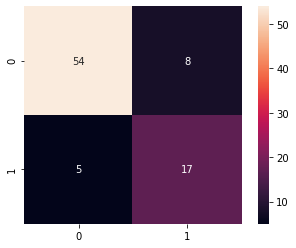

In [16]:
print_scores(wcnb, y_val, X_val)

# Model 2: TFIDF -> NB

In [17]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline([('tfidf', tfidf), ('nb', nb)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [1,2],
    'tfidf__min_df': [1,2],
    'tfidf__preprocessor': [tweet_preprocessor],
    'tfidf__stop_words': ['english'],
    'tfidf__lowercase': [True, False],
    'nb__alpha': [1, 2]
}

In [18]:
tfidfnb = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, cv=3, scoring=LogLoss)

In [19]:
%%time
tfidfnb.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.53994081 -0.54637712         nan         nan -0.52354619 -0.53487883
 -0.52761752 -0.53254898 -0.53994081 -0.54637712         nan         nan
 -0.52354619 -0.53487883 -0.52761752 -0.53254898 -0.5474723  -0.55206588
         nan         nan -0.53712349 -0.54499579 -0.53581425 -0.53878545
 -0.5474723  -0.55206588         nan         nan -0.53712349 -0.54499579
 -0.53581425 -0.53878545]
  warnings.warn(
/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 2.32 s, sys: 33.8 ms, total: 2.35 s
Wall time: 58.3 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(strip_accents='ascii')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1, 2], 'tfidf__lowercase': [True, False],
                         'tfidf__max_df': [1, 2], 'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__preprocessor': [<function tweet_preprocessor at 0x7feb19469430>],
                         'tfidf__stop_words': ['english']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=50)

In [20]:
tfidfnb.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=2,
                                 preprocessor=<function tweet_preprocessor at 0x7feb19469430>,
                                 stop_words='english', strip_accents='ascii')),
                ('nb', MultinomialNB(alpha=1))])

In [21]:
tfidfnb.best_params_

{'nb__alpha': 1,
 'tfidf__lowercase': True,
 'tfidf__max_df': 2,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'tfidf__stop_words': 'english'}

In [22]:
tfidfnb.best_score_

-0.5235461888252514

              precision    recall  f1-score   support

  irrelevant       0.72      0.98      0.83        59
    relevant       0.75      0.12      0.21        25

    accuracy                           0.73        84
   macro avg       0.74      0.55      0.52        84
weighted avg       0.73      0.73      0.65        84

Log Loss: 0.55115


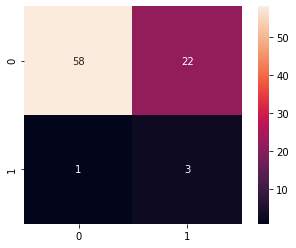

In [23]:
print_scores(tfidfnb, y_val, X_val)

# Model 3: Count -> SVG

In [24]:
count_vec = CountVectorizer(strip_accents='ascii')
svmc = SVC(probability=True)
pipeline = Pipeline([('count', count_vec), ('svm', svmc)])
params = {
    'count__ngram_range': [(1,2), (1,1)],
    'count__min_df': [0, 1],
    'count__preprocessor': [tweet_preprocessor],
    'count__stop_words': ['english'],
    'count__lowercase': [True, False],
    'svm__kernel': ['linear', 'sigmoid'],
    'svm__C': [1, 5],
    'svm__class_weight': ['balanced'],
}

In [25]:
cvsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=30, cv=3, scoring=LogLoss)

In [26]:
%%time
cvsvm.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 2.5 s, sys: 38.7 ms, total: 2.54 s
Wall time: 1min 2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(strip_accents='ascii')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'count__lowercase': [True, False],
                         'count__min_df': [0, 1],
                         'count__ngram_range': [(1, 2), (1, 1)],
                         'count__preprocessor': [<function tweet_preprocessor at 0x7feb19469430>],
                         'count__stop_words': ['english'], 'svm__C': [1, 5],
                         'svm__class_weight': ['balanced'],
                         'svm__kernel': ['linear', 'sigmoid']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=30)

In [27]:
cvsvm.best_estimator_

Pipeline(steps=[('count',
                 CountVectorizer(min_df=0,
                                 preprocessor=<function tweet_preprocessor at 0x7feb19469430>,
                                 stop_words='english', strip_accents='ascii')),
                ('svm',
                 SVC(C=1, class_weight='balanced', kernel='linear',
                     probability=True))])

In [28]:
cvsvm.best_params_

{'count__lowercase': True,
 'count__min_df': 0,
 'count__ngram_range': (1, 1),
 'count__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'count__stop_words': 'english',
 'svm__C': 1,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'linear'}

In [29]:
cvsvm.best_score_

-0.4106674087610867

              precision    recall  f1-score   support

  irrelevant       0.75      0.88      0.81        59
    relevant       0.53      0.32      0.40        25

    accuracy                           0.71        84
   macro avg       0.64      0.60      0.61        84
weighted avg       0.69      0.71      0.69        84

Log Loss: 0.57381


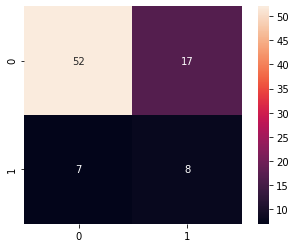

In [30]:
print_scores(cvsvm, y_val, X_val)

# Model 4: tfidf -> SVM

In [31]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii')
svmc = SVC(probability=True)
pipeline = Pipeline([('tfidf', tfidf), ('svm', svmc)])
params = {
    'tfidf__ngram_range': [(1,2), (1,1)],
    'tfidf__min_df': [0, 1],
    'tfidf__lowercase': [True, False],
    'tfidf__preprocessor': [tweet_preprocessor],
    'tfidf__stop_words': ['english'],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [1, 5, 10],
    'svm__class_weight': ['balanced'],
}

In [32]:
tfidfsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, scoring=LogLoss)

In [33]:
%%time
tfidfsvm.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 3.89 s, sys: 140 ms, total: 4.03 s
Wall time: 5min 39s


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(strip_accents='ascii')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 5, 10],
                         'svm__class_weight': ['balanced'],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tfidf__lowercase': [True, False],
                         'tfidf__min_df': [0, 1],
                         'tfidf__ngram_range': [(1, 2), (1, 1)],
                         'tfidf__preprocessor': [<function tweet_preprocessor at 0x7feb19469430>],
                         'tfidf__stop_words': ['english']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=50)

In [34]:
tfidfsvm.best_params_

{'svm__C': 5,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'rbf',
 'tfidf__lowercase': True,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'tfidf__stop_words': 'english'}

In [35]:
tfidfsvm.best_score_

-0.45615046304853957

              precision    recall  f1-score   support

  irrelevant       0.73      0.97      0.83        59
    relevant       0.67      0.16      0.26        25

    accuracy                           0.73        84
   macro avg       0.70      0.56      0.55        84
weighted avg       0.71      0.73      0.66        84

Log Loss: 0.53623


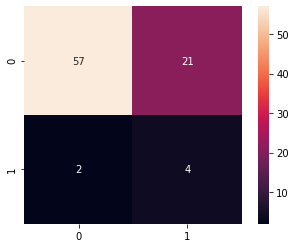

In [36]:
print_scores(tfidfsvm, y_val, X_val)

# Selecting best candidate model

In [37]:
models = [wcnb, cvsvm, tfidfsvm, tfidfnb]
model_scores = [log_loss(y_val, model.predict_proba(X_val)[:,1]) for model in models]
final_model = models[np.argmin(model_scores)]
final_model

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('wordcount',
                                        CountVectorizer(strip_accents='ascii')),
                                       ('bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [1, 2],
                         'wordcount__lowercase': [True, False],
                         'wordcount__min_df': [0, 1, 2],
                         'wordcount__ngram_range': [(1, 2), (1, 1)],
                         'wordcount__preprocessor': [<function tweet_preprocessor at 0x7feb19469430>],
                         'wordcount__stop_words': ['english']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=50)

Looks like the best model is CV->SVC

# Test final model on test set

              precision    recall  f1-score   support

  irrelevant       0.89      0.91      0.90        68
    relevant       0.60      0.53      0.56        17

    accuracy                           0.84        85
   macro avg       0.74      0.72      0.73        85
weighted avg       0.83      0.84      0.83        85

Log Loss: 0.42854


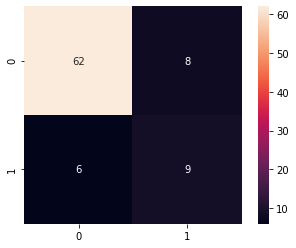

In [38]:
print_scores(final_model, y_test, X_test)

# Compare Final Model to Current Best Model

In [39]:
import joblib

In [40]:
best_model = joblib.load('../bayes_model/best_bayes_pipeline.pkl')

In [41]:
print(best_model.predict(['I saw a coyote this afternoon running across the road']))

[1.]


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [42]:
print(final_model.predict(['I saw a coyote this afternoon running across the road']))

[0.]


              precision    recall  f1-score   support

  irrelevant       0.90      0.90      0.90        59
    relevant       0.76      0.76      0.76        25

    accuracy                           0.86        84
   macro avg       0.83      0.83      0.83        84
weighted avg       0.86      0.86      0.86        84

Log Loss: 0.43113


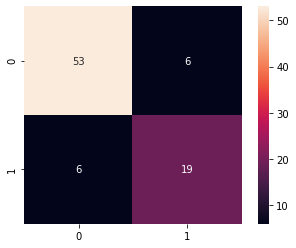

In [43]:
print_scores(best_model, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.87      0.92      0.89        59
    relevant       0.77      0.68      0.72        25

    accuracy                           0.85        84
   macro avg       0.82      0.80      0.81        84
weighted avg       0.84      0.85      0.84        84

Log Loss: 0.45355


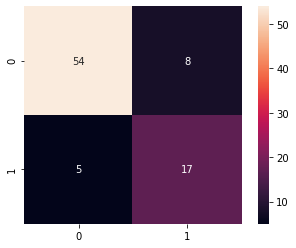

In [44]:
print_scores(final_model, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.92      0.90      0.91        68
    relevant       0.63      0.71      0.67        17

    accuracy                           0.86        85
   macro avg       0.78      0.80      0.79        85
weighted avg       0.87      0.86      0.86        85

Log Loss: 0.34735


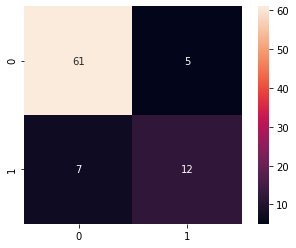

In [45]:
print_scores(best_model, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.89      0.91      0.90        68
    relevant       0.60      0.53      0.56        17

    accuracy                           0.84        85
   macro avg       0.74      0.72      0.73        85
weighted avg       0.83      0.84      0.83        85

Log Loss: 0.42854


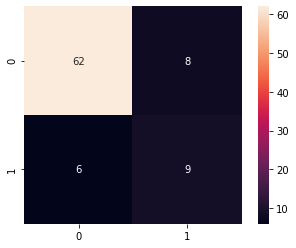

In [46]:
print_scores(final_model, y_test, X_test)

The final model preforms worse than the current best model. The current best model will be the one used.

In [47]:
best_model.best_params_

{'bayes__alpha': 1,
 'wordcount__lowercase': True,
 'wordcount__min_df': 2,
 'wordcount__ngram_range': (1, 2),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english',
 'wordcount__strip_accents': 'ascii'}

In [48]:
wc = CountVectorizer(lowercase=True, min_df=2, ngram_range=(1,2), preprocessor=tweet_preprocessor_old, stop_words='english', strip_accents='ascii')
nb = MultinomialNB(alpha=1)
best_remake = Pipeline([('wc', wc), ('nb', nb)])

In [49]:
best_remake.fit(X_train, y_train)

/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('wc',
                 CountVectorizer(min_df=2, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor_old at 0x7feb194693a0>,
                                 stop_words='english', strip_accents='ascii')),
                ('nb', MultinomialNB(alpha=1))])

In [50]:
y_hat = best_remake.predict_proba(X_train)[:,1]
log_loss(y_train,y_hat)

0.14116387647857692

              precision    recall  f1-score   support

  irrelevant       0.80      0.90      0.85        59
    relevant       0.67      0.48      0.56        25

    accuracy                           0.77        84
   macro avg       0.73      0.69      0.70        84
weighted avg       0.76      0.77      0.76        84

Log Loss: 0.58936


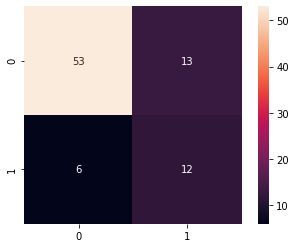

In [51]:
print_scores(best_remake, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.97      0.97      0.97       190
    relevant       0.92      0.92      0.92        63

    accuracy                           0.96       253
   macro avg       0.95      0.95      0.95       253
weighted avg       0.96      0.96      0.96       253

Log Loss: 0.14116


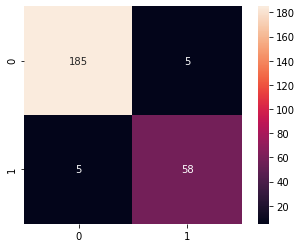

In [52]:
print_scores(best_remake, y_train, X_train)

              precision    recall  f1-score   support

  irrelevant       0.92      0.90      0.91        68
    relevant       0.63      0.71      0.67        17

    accuracy                           0.86        85
   macro avg       0.78      0.80      0.79        85
weighted avg       0.87      0.86      0.86        85

Log Loss: 0.34735


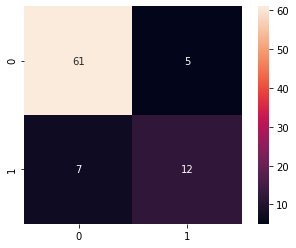

In [53]:
print_scores(best_model, y_test, X_test)